# Mobility for resilience: displacement analysis

This notebook shows how to transform raw mobility data to a displacement analsysis using `mobilkit`.

We start loading raw HFLB data using the `mobilkit.loader` module.

Then, we import a shapefile to tessellate data and dynamically analize where people spend time during night before and after a major event (Puebla 2017 earthquake in Mexico). Different stratification (spatial and socio-economic) of the displacement rate are shown.

In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

import glob, os
from datetime import datetime as dt
from datetime import timedelta, datetime
from datetime import timezone
import pytz
from math import sin, cos, sqrt, atan2, radians
from scipy.optimize import minimize
from scipy import stats

### import Dask library (https://dask.org/)
import dask
import dask.dataframe as dd
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

### import geospatial libraries
import geopandas as gpd
from haversine import haversine
import contextily as ctx
import pyproj

### directory that contains dataset(s) you want to analyze
filepath = "/data/WB_Mexico/gpsdata_eq/testdata_all/"
datapath = "../../data/"
outpath  = "../../results/"

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Import external data 
### Administrative boundary shapefiles

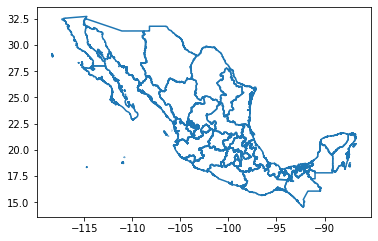

In [5]:
fig,ax = plt.subplots()
adm1_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm1_govmex/"
adm1_shp = gpd.read_file(adm1_f)
adm1_shp.boundary.plot(ax=ax)
plt.show()

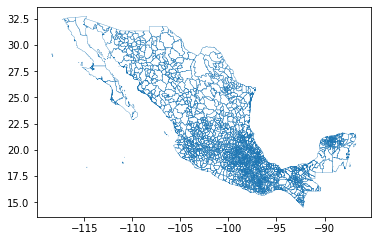

In [33]:
fig,ax = plt.subplots()
adm2_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm2_govmex/"
adm2_shp = gpd.read_file(adm2_f)
adm2_shp = adm2_shp[["ADM2_PCODE","ADM2_ES","geometry"]]
adm2_shp.boundary.plot(ax=ax, linewidth=.3)
plt.show()

In [34]:
adm2_shp.head()

,ADM2_PCODE,ADM2_ES,geometry
0,MX01001,Aguascalientes,"POLYGON ((-102.09775 22.02325, -102.09857 22.0..."
1,MX01002,Asientos,"POLYGON ((-101.99941 22.21951, -101.99940 22.2..."
2,MX01003,Calvillo,"POLYGON ((-102.57625 21.96778, -102.57626 21.9..."
3,MX01004,Cos,"POLYGON ((-102.25320 22.37449, -102.25239 22.3..."
4,MX01005,Jes,"POLYGON ((-102.31034 22.03716, -102.30653 22.0..."


In [38]:
# Turn into a centroid
adm2_shp["centroid"] = adm2_shp.centroid
adm2_shp.geometry = adm2_shp.centroid

<AxesSubplot:>

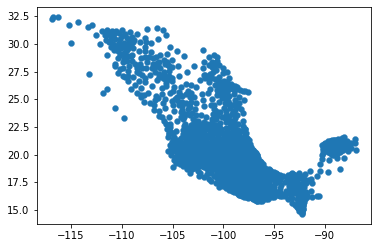

In [40]:
fig,ax = plt.subplots()
adm2_shp.plot(ax=ax, linewidth=.3)

### Seismic intensity shapefile 

In [41]:
seismic_shp_f = datapath+"spatial/seismicdata/intensity/"
seismic_shp = gpd.read_file(seismic_shp_f)[["PARAMVALUE","geometry"]]

In [42]:
seismic_shp.tail()

,PARAMVALUE,geometry
20,7.0,"MULTIPOLYGON (((-99.00292 19.21667, -99.00471 ..."
21,7.2,"MULTIPOLYGON (((-98.74806 18.85833, -98.74864 ..."
22,7.4,"MULTIPOLYGON (((-98.67707 18.80000, -98.67940 ..."
23,7.6,"MULTIPOLYGON (((-98.44767 18.70000, -98.44861 ..."
24,7.8,"MULTIPOLYGON (((-98.48333 18.39997, -98.48336 ..."


In [43]:
seismic_shp_hm = seismic_shp.to_crs(epsg=3857)

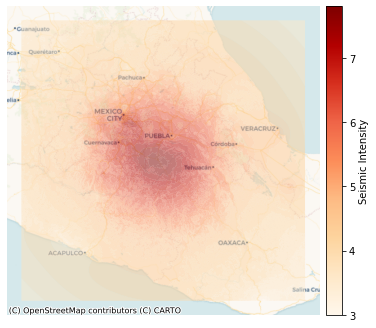

In [44]:
fig,ax = plt.subplots(1,1,figsize=(6,6)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
seismic_shp_hm.plot(ax=ax, column='PARAMVALUE', legend=True, cmap='OrRd', 
                 cax=cax, legend_kwds={'label': "Seismic Intensity"}, 
                 zorder=2.5, alpha=0.5)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
ax.set_axis_off()
plt.show()

In [45]:
adm2_SI = gpd.sjoin(adm2_shp, seismic_shp, how="left", \
                    op='intersects')[["ADM2_PCODE","PARAMVALUE"]]

In [46]:
adm2_SI[adm2_SI["ADM2_PCODE"]=="MX09002"]

,ADM2_PCODE,PARAMVALUE
265,MX09002,6.0


### Population data

In [47]:
poppath = datapath+"sociodemographic/populationdata/"
df_pop = pd.DataFrame()
# Load only the states we are interested in
for es in ["09","17","21","29"]:
    pop = poppath+"resultados_ageb_urbana_"+es+"_cpv2010.csv"
    df_pop1 = pd.read_csv(pop)[["entidad","mun","loc","ageb","mza","pobtot"]]
    df_pop = df_pop.append(df_pop1, ignore_index=True)

df_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]==0)][["entidad","mun","pobtot"]]

df_pop["PCODE"] = df_pop.apply(lambda row : "MX"+str(row["entidad"]).zfill(2)+str(row["mun"]).zfill(3), axis=1)

In [50]:
df_pop.head()

,entidad,mun,pobtot,PCODE
1,9,2,414711,MX09002
3097,9,3,620416,MX09003
7970,9,4,186391,MX09004
9010,9,5,1185772,MX09005
17648,9,6,384326,MX09006


In [51]:
adm2_SI_pop = adm2_SI.merge(df_pop, left_on="ADM2_PCODE", right_on="PCODE")[["PCODE","PARAMVALUE","pobtot"]]

In [52]:
adm2_SI_pop.head()

,PCODE,PARAMVALUE,pobtot
0,MX09002,6.0,414711
1,MX09003,6.8,620416
2,MX09004,6.2,186391
3,MX09005,5.4,1185772
4,MX09006,6.6,384326


### Wealth index data 

In [53]:
wealthidx_f = datapath+"sociodemographic/wealthindex/pca_index_AGEBS_localidades.csv"
wealthidx = pd.read_csv(wealthidx_f, header=0, 
                        names = ["index","code","pca","index_pca"])
wealthidx.head()

/home/ubi/Sandbox/mobilkit_dask/mobenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,index,code,pca,index_pca
0,0,0100100010229,-2.680167,0.147990
1,1,0100100010233,-2.701735,0.146480
2,2,0100100010286,-3.474532,0.092363
3,3,0100100010290,-3.404371,0.097277
4,4,0100100010303,-3.099987,0.118592


In [54]:
wealthidx["PCODE"] = wealthidx["code"].apply(lambda x : "MX"+str(x)[:5])
wealthidx_avg = wealthidx.groupby("PCODE")["index_pca"].mean().reset_index()

In [56]:
wealthidx_avg.head()

,PCODE,index_pca
0,MX01001,0.206558
1,MX01002,0.232278
2,MX01003,0.233212
3,MX01004,0.216361
4,MX01005,0.216503


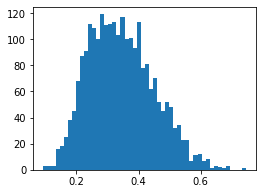

In [57]:
plt.figure(figsize=(4,3))
plt.hist(wealthidx_avg["index_pca"].values, bins=50)
plt.show()

In [58]:
# Merge this info in the code mapping df
adm2_SI_pop_WI = adm2_SI_pop.merge(wealthidx_avg, on="PCODE")

In [59]:
adm2_SI_pop_WI.head(10)

,PCODE,PARAMVALUE,pobtot,index_pca
0,MX09002,6.0,414711,0.124537
1,MX09003,6.8,620416,0.106024
2,MX09004,6.2,186391,0.182998
3,MX09005,5.4,1185772,0.140297
4,MX09006,6.6,384326,0.134230
5,MX09007,7.0,1815786,0.157710
6,MX09008,6.0,239086,0.181795
7,MX09009,7.0,130582,0.285495
8,MX09010,6.8,727034,0.135709
9,MX09011,7.4,360265,0.199308


## Compute displacement rate 
### Get valid user IDs
Filter users based on statistic.

In [1]:
idhome = "data/id_home_3_1.csv"
df_idhome = pd.read_csv(idhome)
df_idhome["home"] = df_idhome["home"].apply(lambda v: [e for e in v.replace("[","")
                                                       .replace("]","")
                                                        .split(" ")
                                                       if len(e)>0])
df_idhome["homelat"] = df_idhome["home"].apply(lambda v: float(v[1]))
df_idhome["homelon"] = df_idhome["home"].apply(lambda v: float(v[0]))
df_idhome = df_idhome[["uid","homelat","homelon"]].copy()
allids = set(df_idhome["uid"].values)

In [7]:
df_idhome.shape

(279541, 3)

In [9]:
len(allids)

279541

## Extract data of above IDs

We just lazily load the data and then filter on the ids.
We get for free the localized datetime column.

If you want to persist these data separated per user at the different steps we show how to do it.

We connect to dask and then load and filter data.

In [12]:
client = Client(address="127.0.0.1:8786", )

{'tcp://127.0.0.1:38661': {'status': 'OK'},
 'tcp://127.0.0.1:39151': {'status': 'OK'},
 'tcp://127.0.0.1:39553': {'status': 'OK'},
 'tcp://127.0.0.1:40421': {'status': 'OK'},
 'tcp://127.0.0.1:41351': {'status': 'OK'},
 'tcp://127.0.0.1:42609': {'status': 'OK'},
 'tcp://127.0.0.1:44517': {'status': 'OK'},
 'tcp://127.0.0.1:45691': {'status': 'OK'}}

In [13]:
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 32.00 GB


In [14]:
tz = pytz.timezone("America/Mexico_City")
alldataf = dd.read_parquet("/data/datiHFLBPARQUET/")
filtered_dataf = mobilkit.stats.filterUsersFromSet(alldataf, allids)

In [19]:
if False:
    # Now we can persist these data as in the original example
    # I prefer to use the parquet format which is faster
    alldataf = "../../results/displacement_selectedids_all_data"
    filtered_dataf.repartition(partition_size="20M").to_parquet(alldataf)

In [2]:
# Now I can quickly reload this first step of selection
alldataf = "../../results/displacement_selectedids_all_data"
filtered_dataf_reloaded = dd.read_parquet(alldataf).repartition(partition_size="200M")
if "datetime" not in filtered_dataf_reloaded.columns:
    # Add datetime column
    import pytz
    tz = pytz.timezone("America/Mexico_City")
    # Filter on dates...
    filtered_dataf_reloaded = mobilkit.loader.filterStartStopDates(filtered_dataf_reloaded,
                                                    start_date="2017-09-04",
                                                      stop_date="2017-10-08",
                                                      tz=tz,)
    filtered_dataf_reloaded = mobilkit.loader.compute_datetime_col(filtered_dataf_reloaded, selected_tz=tz)

## Get daily displacement distance

All these computing times are obtained on a personal laptop local cluster with:

```
Client
Scheduler: tcp://127.0.0.1:8786
Dashboard: http://127.0.0.1:8787/status
Cluster
Workers: 3
Cores: 3
Memory: 28.00 GB

```

for limited I/O performances. These should scale better on a cluster.

In [28]:
# Prepare pings adding date and filtering on hour...
df_displacement_ready = mobilkit.temporal.filter_daynight_time(
                                                filtered_dataf_reloaded,
                                                filter_to_h=9,
                                                filter_from_h=21,
                                                previous_day_until_h=4,
                                            )

In [28]:
# We now compute the displacement figures in one line and save it to disk
processed_diplacement = mobilkit.displacement.calc_displacement(df_displacement_ready,
                                                                df_idhome)

In [29]:
# Persist to disk
tic = datetime.now()
if False:
    processed_diplacement.to_parquet("../../results/displacement_selectedids_processed/")
else:
    processed_diplacement = dd.read_parquet("../../results/displacement_selectedids_processed/")
toc = datetime.now()

In [30]:
tot_sec = (toc - tic).total_seconds()
print("Done in %d hours and %.01f minutes!" % (tot_sec//3600, (tot_sec % 3600)/60))

Done in 2 hours and 21.7 minutes!


In [31]:
# Total number of users and number of pings
stats_df = filtered_dataf_reloaded.groupby("uid").agg("count").compute()
print("Users:", stats_df.shape[0])
print("Pings:", stats_df["lat"].sum())

Users: 279541
Pings: 318852179


## Analyze displacement rates 
### Per-id home location

In [60]:
# Transform the data in a geodataframe for spatial queries
idhome_gdf = gpd.GeoDataFrame(df_idhome,
                              geometry=gpd.points_from_xy(df_idhome.homelon,
                                                          df_idhome.homelat))

In [121]:
adm2_f = datapath + "spatial/boundaries_shapefiles/mex_admbnda_adm2_govmex/"
adm2_shp = gpd.read_file(adm2_f)

In [63]:
# Spatial join, then I can aggregate by Municipality or other features
id_homecode = gpd.sjoin(idhome_gdf,adm2_shp[["ADM2_PCODE","geometry"]])
id_homecode = id_homecode[["uid","homelon",
                           "homelat","ADM2_PCODE"]].rename(columns={"ADM2_PCODE":"PCODE"}) 

<ipython-input-63-ec4458acad15>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  id_homecode = gpd.sjoin(idhome_gdf,adm2_shp)


In [3]:
id_home_feat = id_homecode.merge(adm2_SI_pop_WI, on="PCODE")

In [66]:
muncode_count = id_homecode.groupby("PCODE").count().reset_index()

In [3]:
muncode_rate = muncode_count.merge(adm2_SI_pop_WI, on ="PCODE")
muncode_rate["rate"] = muncode_rate["uid"]/muncode_rate["pobtot"]

## Macroscopic analysis

Reload previous results and stratify by different user status.

### Seismic intensity

In [71]:
df_disp = dd.read_parquet("results/displacement_selectedids_processed/")

In [72]:
# Now we are working on dask, I port to pandas with .compute()
df_disp2 = df_disp.merge(id_homecode, on="uid", how="left").compute()

In [74]:
df_disp3 = df_disp2.merge(adm2_SI_pop_WI, on="PCODE", how="left")

In [76]:
# Helper function to determine the Seismic intensity level
def categorizeSI(si):
    if si>=7:
        r = 7
    elif si>=6.5:
        r = 6.5
    elif si>=6:
        r = 6
    elif si >=5:
        r = 5
    elif si >=4:
        r = 4
    else:
        r = 0
    return r

In [77]:
df_disp3["SI_cat"] = df_disp3["PARAMVALUE"].apply(lambda x : categorizeSI(x))

#### Compute displacement rates

In [4]:
df_disp4 = df_disp3[df_disp3["lng"]!=0].copy()

In [80]:
dist = "mindist"
df_disp4["500m"] = df_disp4[dist].apply(lambda x : 1 if x>0.5 else 0)
df_disp4["1km"] = df_disp4[dist].apply(lambda x : 1 if x>1 else 0)
df_disp4["3km"] = df_disp4[dist].apply(lambda x : 1 if x>3 else 0)
df_disp4["5km"] = df_disp4[dist].apply(lambda x : 1 if x>5 else 0)
df_disp4["10km"] = df_disp4[dist].apply(lambda x : 1 if x>10 else 0)

In [5]:
si_count = df_disp4[df_disp4["date"]==dt(2017,9, 3)]\
                                    .groupby('SI_cat')\
                                    .agg("count").reset_index()

#### Displacement plot by SI

In [84]:
sis = sorted(set(df_disp4["SI_cat"]))
sis = [5.0, 6.0, 6.5, 7.0]

cms = plt.get_cmap("jet",len(sis))

scale = "500m"

df_this = df_disp4[df_disp4["SI_cat"]==0]
date_disp = df_this.groupby('date').mean().reset_index()
date_disp["date_dt"] = date_disp["date"].values# apply(lambda x : dt.strptime(str(x), '%Y%m%d'))
baseline = date_disp["500m"].values

In [88]:
from scipy.optimize import minimize

def fit_baseline(data,baseline):
    
    def axb(p,x):    
        return p[0]*x
    
    def errortot(data, baseline):
        tot = 0
        for i in np.arange(15):
            tot = tot + (baseline[i]-data[i])**2
        return tot
    
    x0 = np.array([1])
    res = minimize(lambda p: errortot(axb(p, data), baseline), x0=x0, method='Powell')

    return res.x

In [137]:
def plotforSI(df_disp_se,si,ax,color, category, label, ylab, colname, baseline):
    df_this = df_disp_se[df_disp_se[category]==si]
    date_count = df_this.groupby('date').count().reset_index()[["date","uid"]]
    date_std = df_this.groupby('date').std().reset_index()[["date",colname]]
    date_std = date_std.rename(columns= {colname:"std"})
    date_disp = df_this.groupby('date').mean().reset_index()
    date_disp["date_dt"] = date_disp["date"].values # .apply(lambda x : dt.strptime(str(x), '%Y%m%d'))
    date_disp["youbi"] = date_disp["date_dt"].apply(lambda x : x.weekday())
    date_disp = date_disp.merge(date_count, on="date")
    date_disp = date_disp.merge(date_std, on="date")

    data = date_disp[colname].values
    a = fit_baseline(data, baseline)
    print(a.shape, data.shape, baseline.shape)
    res = (a*data-baseline)*100
    ax.plot(date_disp["date_dt"],res, color=color, label="Estimated")
    date_disp["error"] = date_disp.apply(lambda x : 196*np.sqrt((x[colname]*(1-x[colname]))/x["uid"]), \
                                             axis=1)
    
    ax.fill_between(date_disp["date_dt"],res-date_disp["error"].values, \
                    res+date_disp["error"].values, 
                    color=color, alpha=0.3, label="95% CI")
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    ax.axhline(0, color="gray")
    # ax.set_xticks(["20170905","20170915","20170925","20171005"])
    ax.set_ylim(-2.5,6)
    ax.set_ylabel(ylab[0], fontsize=12)
    ax.axvline(datetime(2017,9,19), color="red")
    ax.legend(fontsize=12, ncol=5, loc="upper left")
    ax.set_title(label, fontsize=14)

(1,) (35,) (35,)
(1,) (35,) (35,)
(1,) (35,) (35,)
(1,) (35,) (35,)


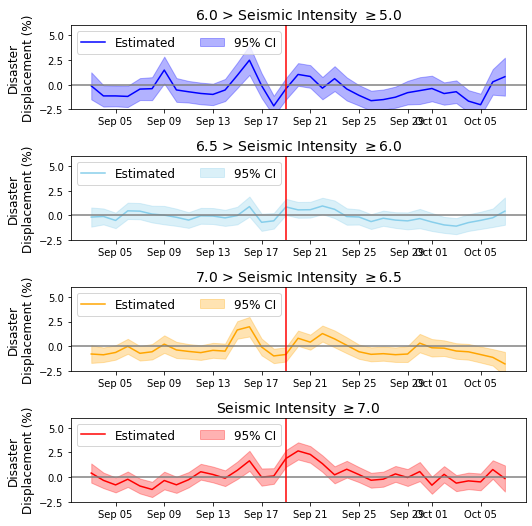

In [138]:
fig=plt.figure(figsize=(7.5,9))
gs=GridSpec(5,1)

res_si = {}

category = "SI_cat"
ylabs = ["Disaster\nDisplacement (%)", "$\Delta D$"]
colors = ["blue", "skyblue", "orange", "red"]
titles = ["6.0 > Seismic Intensity "+r"$\geq$"+"5.0", 
          "6.5 > Seismic Intensity "+r"$\geq$"+"6.0", 
          "7.0 > Seismic Intensity "+r"$\geq$"+"6.5",
          "Seismic Intensity "+r"$\geq$"+"7.0"]
for si,i in zip(sis,np.arange(len(sis))):
    ax = fig.add_subplot(gs[i,0]) 
    plotforSI(df_disp4, si, ax, colors[i], category, titles[i], ylabs, scale, baseline)        

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/displacement_si.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

### Displacement rate by wealth index

In [6]:
df_disp_se_5 = df_disp4[df_disp4["SI_cat"]>=6.5]

In [92]:
aaa = df_disp_se_5[df_disp_se_5["date"]==dt(2017,9,8)].groupby("index_pca")["500m"].mean().reset_index()
bbb = df_disp_se_5[df_disp_se_5["date"]==dt(2017,9,8)].groupby("index_pca")["500m"].count().reset_index()

aaa.shape, bbb.shape

((106, 2), (106, 2))

In [114]:
x = aaa["index_pca"].values
y = aaa["500m"].values
z = bbb["500m"].values
newz = []
xx = []
yy = []
for k,j,i in zip(x,y,z):
    if i > 20:
        xx.append(k)
        yy.append(j*100-baseline[15]*100)
        newz.append(np.sqrt(i)*5)

-25.29461166237592 4.122102681557249 -0.39968759624164824 0.01736848907416504 10.098447012463001


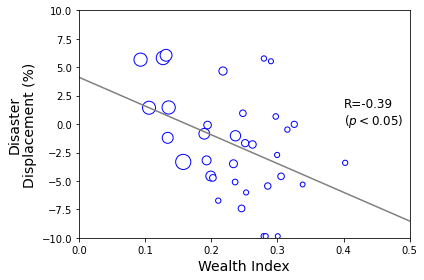

In [115]:
plt.scatter(xx, yy, s=newz, edgecolor="b", facecolor="white")
c1, i1, s1, p_value, std_err = stats.linregress(xx,yy)
print(c1, i1, s1, p_value, std_err)
plt.plot([0,1],[i1,i1+c1], linestyle="-", color="gray") 
plt.annotate("R="+str(s1)[:5]+"\n($p<0.05$)", xy=(0.4,0), fontsize=12)
plt.ylim(-10,10)
plt.xlim(0,0.5)
plt.xlabel("Wealth Index", fontsize=14)
plt.ylabel("Disaster\nDisplacement (%)", fontsize=14)

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/wealth_disp.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

### Look at high damage + sample rate areas in detail

In [116]:
### merge with disaster damage data (below)
muncode_rate["idlog"] = muncode_rate["uid"].apply(lambda x : np.log10(x))

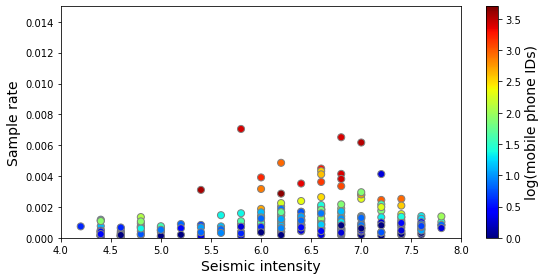

In [118]:
fig=plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)
muncode_rate.plot.scatter("PARAMVALUE","rate",c='idlog', 
                               colormap='jet', edgecolor="gray", s=50,ax=ax)
ax.set_xlim(4,8)
ax.set_ylim(0,0.015)
# ax.set_xticklabels([4,5,6,7,8])
ax.set_xlabel("Seismic intensity", fontsize=14)
ax.set_ylabel("Sample rate", fontsize=14)

f = plt.gcf()
cax = f.get_axes()[1]
cax.set_ylabel('log(mobile phone IDs)', fontsize=14)

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/samplerate_si.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [4]:
target = muncode_rate[(muncode_rate["PARAMVALUE"]>=6.5) & (muncode_rate["uid"]>=30)]

In [120]:
targetcodes = target["PCODE"].values
targetcodes = ['MX09015', 'MX09003', 'MX09010', 'MX09007', 'MX09014', 'MX09017']

In [124]:
names = []
for t in targetcodes:
    name = adm2_shp[adm2_shp["ADM2_PCODE"]==t]["ADM2_ES"].values[0]
    SI = target[target["PCODE"]==t]["PARAMVALUE"].values[0]
    ids = target[target["PCODE"]==t]["uid"].values[0]
    if "Cua" in name:
        name = "Cuauhtemoc"
    elif "lvaro" in name:
        name = "Olvaro Obregzn"
    names.append(name+" (code: "+t+", SI="+str(SI)+", Users="+str(ids)+")")
    
names

['Cuauhtemoc (code: MX09015, SI=7.0, Users=3285)',
 'Coyoacln (code: MX09003, SI=6.8, Users=2570)',
 'Olvaro Obregzn (code: MX09010, SI=6.8, Users=2774)',
 'Iztapalapa (code: MX09007, SI=7.0, Users=5016)',
 'Benito Julrez (code: MX09014, SI=6.8, Users=2512)',
 'Venustiano Carranza (code: MX09017, SI=6.6, Users=1935)']

(1,) (35,) (35,)
(1,) (35,) (35,)
(1,) (35,) (35,)
(1,) (35,) (35,)
(1,) (35,) (35,)
(1,) (35,) (35,)


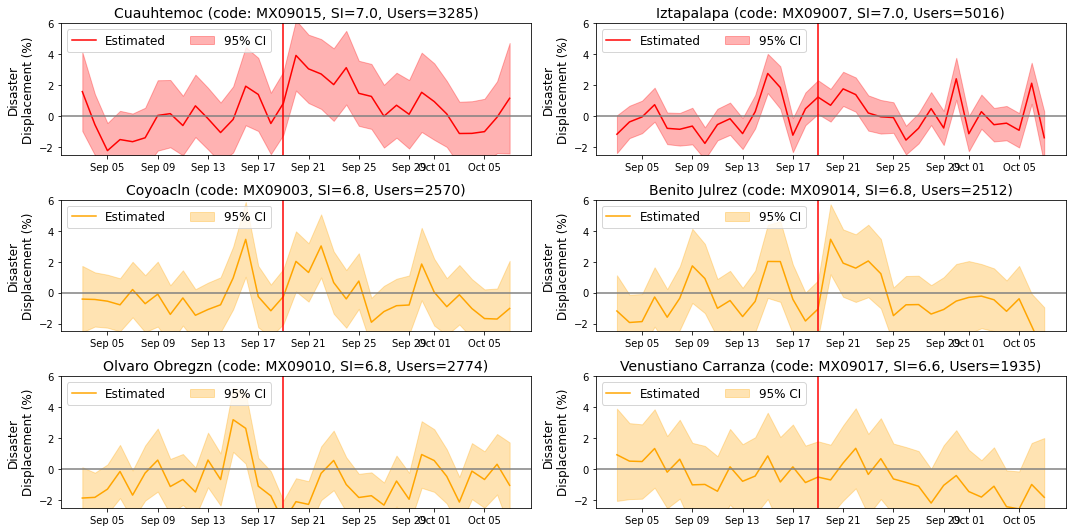

In [139]:
fig=plt.figure(figsize=(15,2.5*3))
gs=GridSpec(3,2)

res_si = {}

category = "PCODE"
ylabs = ["Disaster\nDisplacement (%)", "$\Delta D$"]
colors = ["red", "orange", "orange", "red", "orange", "orange", "orange"]
titles = names

for i,pcode in enumerate(targetcodes):
    x,y = i, 0
    if i>2:
        y = 1
        x = i - 3
#     print(x,y)
    ax = fig.add_subplot(gs[x,y]) 
    plotforSI(df_disp4, pcode, ax, colors[i], category, titles[i], ylabs, scale, baseline)        

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/displacement_places.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## Zoom to Areas of interest
### Cuahtlemoc

In [180]:
date = dt(2017,9,20)
df_disp4_cua = df_disp4[(df_disp4["PCODE"]=="MX09015") & (df_disp4["date"]==date)].copy()
df_disp4_cua["distance"] = df_disp4_cua.apply(lambda row: np.log10(max(.001, 
                        haversine([row["homelat_x"],row["homelon_x"]],
                                  [row["lat"],row["lng"]]))),axis=1)

# df_disp4_cua = df_disp4_cua[(df_disp4_cua["distance"]>2)]
df_disp4_cua = df_disp4_cua[(df_disp4_cua["distance"].between(1e-3, 1000))]

# df_disp4_cua = df_disp4_cua[((df_disp4_cua["distance"]>0.5) & (df_disp4_cua["distance"]<1.5))]

# df_disp4_cua = df_disp4_cua[((df_disp4_cua["distance"]>0.5) & (df_disp4_cua["distance"]<1.5)) | (df_disp4_cua["distance"]<-1)]

df_disp4_cua_gdf = gpd.GeoDataFrame(df_disp4_cua, geometry=gpd.points_from_xy(df_disp4_cua.lng, df_disp4_cua.lat))
df_disp4_cua_gdf = df_disp4_cua_gdf[["uid","geometry"]]

In [181]:
df_disp4_cua_gdf.columns

Index(['uid', 'geometry'], dtype='object')

In [182]:
df_disp4_cua_to = gpd.sjoin(df_disp4_cua_gdf,adm2_shp)

<ipython-input-182-bc7533da0982>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df_disp4_cua_to = gpd.sjoin(df_disp4_cua_gdf,adm2_shp)


In [183]:
targetcode_count = df_disp4_cua_to.groupby("ADM2_PCODE")["uid"].count().reset_index()
targetcode_count["idlog"] = targetcode_count["uid"].apply(lambda x : np.log10(x))

In [184]:
mun_ids_pop_shp = adm2_shp.merge(targetcode_count, on="ADM2_PCODE", how="right")
mun_ids_pop_shp = mun_ids_pop_shp.to_crs(epsg=3857)

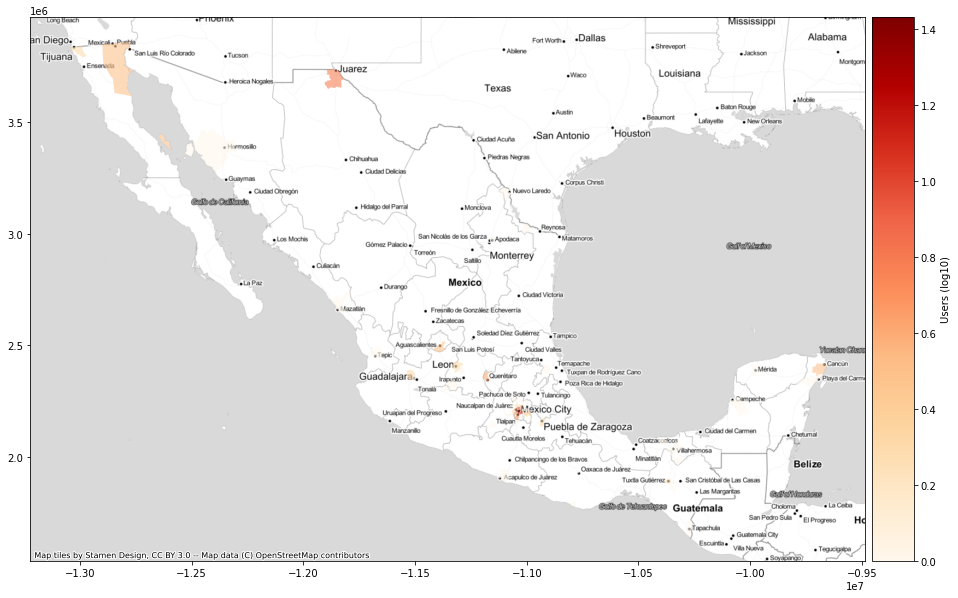

In [185]:
fig,ax = plt.subplots(figsize=(20,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mun_ids_pop_shp.plot(ax=ax, column='idlog', cmap='OrRd', legend=True, 
                    cax=cax, legend_kwds={'label': "Users (log10)"}, alpha=.6)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# plt.savefig("C:/users/yabec/desktop/displacement_10km.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

### Distance of displacement

In [186]:
df_disp4_cua["distance"] = df_disp4_cua.apply(lambda row: np.log10(haversine([row["homelat_x"],row["homelon_x"]],
                                                                             [row["lat"],row["lng"]])),axis=1)

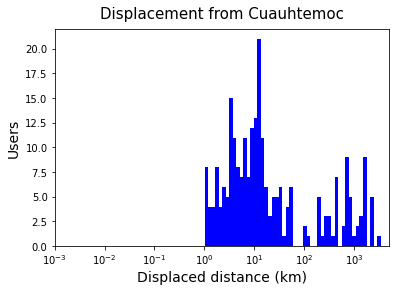

In [187]:
fig,ax = plt.subplots(figsize=(6,4))

ax.hist(df_disp4_cua["distance"].values, bins=50, color="b")
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(["$10^{-3}$","$10^{-2}$","$10^{-1}$","$10^{0}$",
                    "$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_xlabel("Displaced distance (km)", fontsize=14)
ax.set_ylabel("Users", fontsize=14)
ax.set_title("Displacement from Cuauhtemoc", fontsize=15, pad=10)

# plt.savefig("C:/users/yabec/desktop/displacement_distance.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()